In [1]:
from datetime import datetime, date
import pandas as pd
import numpy as np
from scipy import stats
import re, os, nltk, math, csv, json
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Google Drive - This will prompt you to click a link to authorize
# (don't execute if running on own machine)
from google.colab import drive, auth, files
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Google Drive - Navigate to directory
# (don't execute if running on own machine)
os.chdir('drive/MyDrive/SocialComQuant22/')
os.listdir('.')

['Data', 'Resources_geolocation', 'Resources_nutrition', 'Untitled0.ipynb']

# NLP for health - case study of Obesity

In public health research, sometimes we want to extract health-relevant signals, and relate them to some health outcome. In this example, we will learn to:
1. Geo-locate tweets to GeoNames locations
2. Apply a food dictionary to extract caloric information
3. Correlate this caloric information to known obesity rates


In [3]:
# Read in the file containing tweet information
tweets = pd.read_csv("Data/tweet_sample.tsv", sep="\t", lineterminator='\n',
                  low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
                  names=["text", "id", "created_at", "lang", "retweeted_status_id", "retweeted_status_user_id", 
                         "user_id", "user_name", "followers_count", "friends_count", "statuses_count", 
                         "location", "user_created_at", "youtube_ids"],
                  dtype={'id': object, 'retweeted_status_user_id': object, 'retweeted_status_id': object, 'user_id': object})

In [4]:
tweets.shape

(10000, 14)

In [5]:
tweets = tweets.drop_duplicates("id")
tweets.shape

(10000, 14)

In [6]:
tweets.sample(5)

,text,id,created_at,lang,retweeted_status_id,retweeted_status_user_id,user_id,user_name,followers_count,friends_count,statuses_count,location,user_created_at,youtube_ids
4871,I'm live now on #youtube https://t.co/Igt9fdG3...,1203367200209489920,Sat Dec 07 17:34:32 +0000 2019,en,NaN,NaN,875484339777277952,Jamie Brown - Vegan Realist,2141.0,2020.0,7395.0,"Blackburn, England",Thu Jun 15 22:45:07 +0000 2017,cJU8M_Ict6M
4771,My Version Pink Drink MUST SEE! DITL VLOG Ang...,1154312364814192640,Thu Jul 25 08:48:08 +0000 2019,en,NaN,NaN,2850407908,Ketogenic Kim,50.0,21.0,4934.0,None,Wed Oct 29 20:44:28 +0000 2014,sqDRz1KqZss
3924,20 Minute Walk at Home Exercise | Fitness Vide...,1258917368354484230,Sat May 09 00:31:04 +0000 2020,en,NaN,NaN,1879763192,Barrie Howe 2 Heal,546.0,680.0,5728.0,Plymouth,Wed Sep 18 14:53:56 +0000 2013,-SSYX8sIOmM
4278,This video presents Low-carb diets: DO and DON...,1211183229308264448,Sun Dec 29 07:12:39 +0000 2019,en,NaN,NaN,1150668611872157696,healthAndNutrition,20.0,236.0,1501.0,None,Mon Jul 15 07:29:10 +0000 2019,fpj3d-YIjn8
4911,Kale and Potato Soup (Vegan) https://t.co/x0sn...,1196217045056139264,Mon Nov 18 00:02:22 +0000 2019,cs,NaN,NaN,29876833,David Demoise,82.0,59.0,39718.0,America,Thu Apr 09 01:02:24 +0000 2009,HcMClMo_GYU


## 1.1 Geo-location

In [7]:
# Pick only tweets with non-empty location field
tweets_withlocs = tweets[tweets.location!="None"]
tweets_withlocs.shape

(6696, 14)

### Define functions to look up GeoNames entities from text

Read in information necessary for geolocation (may take a minute)

In [2]:
# Dictionary mapping (lower-case) strings of locations to ids of places
locdictionary = json.load(open('Resources_geolocation/locdictionary.json'))
# Data frame mapping ids of places to metadata about these places
locationdata = pd.read_csv("Resources_geolocation/countriesdatap.tsv.gz", sep='\t', low_memory=False, index_col="geonameid")

In [9]:
# Stopwords to remove spurious matches
nltk.download('stopwords')
engstopwords = stopwords.words('english')
numbers = {'zero','one','two','three','four','five','six','seven','eight','nine','ten',
           'eleven','twelve','thirteen','fourteen','fifteen','sixteen','seventeen','eighteen',
           'nineteen','twenty','thirty','fourty','fifty','sixty','seventy','eighty','ninety',
           'hundred','thousand','million','billion','zillion'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ymejova/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Lookup functions ######################################################

# Turn tokens into a sequence of n-grams
def word_ngrams(tokens, ngrams):
    min_n, max_n = 1, ngrams
    if max_n != 1:
        original_tokens = tokens
        tokens = []
        n_original_tokens = len(original_tokens)
        for n in range(min_n, min(max_n + 1, n_original_tokens + 1)):
            for i in range(n_original_tokens - n + 1):
                tokens.append(" ".join(original_tokens[i: i + n]))
    return tokens

# Finds all the longest string matches for a piece of text
tokenizer = RegexpTokenizer(r'\w+')
def find_names(text):
    tokens = word_ngrams(tokenizer.tokenize(text.lower()), 5)
    m = set()
    for token in tokens:
        if token in locdictionary:
            m.add(token)
    # filter out matched places that are substrings of another matched place
    k_list = list(m)
    for i, k in enumerate(k_list):
        for k2 in k_list[:i]:
            if k in k2 and k in m:
                m.remove(k)
        for k2 in k_list[i+1:]:
            if k in k2 and k in m:
                m.remove(k)
    return m

# Finds the best match for the text
# For speed reasons, returns only the geonamesid which can be used to index into locationdata
def find_best_match(text):
    # Try finding all the matches
    mymatches = find_names(text)
    bestmatch = None
    matcharray = []
    matchedids = []
    foundcountry = None
    countrymatches = None
    # Put all the matches in one array
    for foundloc in mymatches:
        matchedids = matchedids + locdictionary[foundloc]
    # If there is more than 1 match, and there is a match to a country, constrain all other matches to that country
    if len(matchedids) > 1:
        matchedlocations = locationdata.loc[matchedids]
        if pd.DataFrame.any(matchedlocations.featurecode=="PCLI"):
            foundcountry = matchedlocations[matchedlocations.featurecode=="PCLI"].iloc[0].countrycode
            countrymatches = matchedlocations[matchedlocations.countrycode==foundcountry]
    # For each word match, find the most populous one
    for foundloc in mymatches:
        # Handle special cases
        if len(foundloc) < 2:
            continue
        if (foundloc in engstopwords) | (foundloc in numbers):
            continue
        if (foundloc=="new york") | (foundloc=="ny") | (foundloc=="ny ny") | (foundloc=="new york ny") | (foundloc=="nyc"):
            matcharray.append(5128581) # city, not state
        if (foundloc=="he his") | (foundloc=="she her") | (foundloc=="he") | (foundloc=="his") | \
        (foundloc=="she") | (foundloc=="her") | (foundloc=="they") | (foundloc=="them") | (foundloc=="they them"):
            continue
        if (foundloc=="none") | (foundloc=="null") | (foundloc=="na") | (foundloc=="nan"):
            continue
        if (foundloc=="secret") | (foundloc=="zone") | (foundloc=="hell") | (foundloc=="landing") | (foundloc=="rainbow") |\
        (foundloc=="south") | (foundloc=="north") | (foundloc=="east") | (foundloc=="west") | \
        (foundloc=="southeast") | (foundloc=="northeast") | (foundloc=="southwest") | (foundloc=="northwest") | \
        (foundloc=="se") | (foundloc=="ne") | (foundloc=="sw") | (foundloc=="nw"):
            continue
        else:
            matchedlocations = locationdata.loc[locdictionary[foundloc],:]
            if foundcountry: # Remove matches that are not in the country we found
                matchedlocations = matchedlocations[matchedlocations.countrycode==foundcountry]
            if matchedlocations.shape[0] > 0:
                foundmatch = matchedlocations.sort_values(by="population",ascending=False).index[0]
                matcharray.append(foundmatch)
    # Among all the matches, find the least populous one
    if len(matcharray) > 0:
        allmatches = locationdata.loc[matcharray]
        bestmatch = allmatches.sort_values(by="population",ascending=True).index[0]
    return bestmatch

### Apply GeoNames tagging to our data

(may take a minutes)

In [11]:
# Find the geonames IDs of best matches
tweets_withlocs["geonameid"] = tweets_withlocs["location"].apply(lambda x: find_best_match(x))

/var/folders/12/9ngr75n132qbdvxgkxdfxpnh0000gn/T/ipykernel_1987/1024083383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_withlocs["geonameid"] = tweets_withlocs["location"].apply(lambda x: find_best_match(x))


In [12]:
# Number of records that have non-empty matches
tweets_withlocs = tweets_withlocs[~tweets_withlocs["geonameid"].isna()]
tweets_withlocs.shape

(6159, 15)

In [13]:
# Join with the rest of information on the location
interesting_columns = ['geonameid', 'name', 'asciiname', 'latitude', 'longitude',
       'featureclass', 'featurecode', 'countrycode', 'cc2', 'admin1code', 'population', 'timezone']
tweets_withlocs_info = tweets_withlocs.merge(locationdata.reset_index()[interesting_columns], on="geonameid")
tweets_withlocs_info.shape

(6159, 26)

In [14]:
tweets_withlocs_info.sample(5)

,text,id,created_at,lang,retweeted_status_id,retweeted_status_user_id,user_id,user_name,followers_count,friends_count,...,asciiname,latitude,longitude,featureclass,featurecode,countrycode,cc2,admin1code,population,timezone
2867,Easy Keto Fat Bombs💣3 Base Ingredients💣LOW NET...,1188077119722721281,Sat Oct 26 12:57:13 +0000 2019,en,NaN,NaN,1021828822033997824,Sandra Cunningham,12.0,96.0,...,Grimsby,53.56539,-0.07553,P,PPLA2,GB,GB,ENG,134160,Europe/London
2412,RT @CFVanity: ONE BRAND #REVIEW OSEA (#VEGAN &...,1200477426435993601,Fri Nov 29 18:11:36 +0000 2019,en,1.2004774029980426e+18,1.0738123385730785e+18,3208024522,Tweets for Vegans,24879.0,11299.0,...,Landes,45.99222,-0.59750,A,ADM4,FR,NaN,75,610,Europe/Paris
2573,I'm live now on #youtube https://t.co/UvSNILfp...,1189453524012359681,Wed Oct 30 08:06:33 +0000 2019,en,NaN,NaN,875484339777277952,Jamie Brown - Vegan Realist,2035.0,1877.0,...,Blackburn,53.75000,-2.48333,P,PPLA2,GB,NaN,ENG,146521,Europe/London
1517,How I Tricked My Brain To Like Doing Hard Thin...,1260957445368811520,Thu May 14 15:37:37 +0000 2020,en,NaN,NaN,1219332041315143682,LittleFinger,6.0,98.0,...,New York City,40.71427,-74.00597,P,PPL,US,NaN,NY,8175133,America/New_York
746,My 'Oil: The Vegan Killer' Video Was Debunked?...,1150515245284302850,Sun Jul 14 21:19:44 +0000 2019,en,NaN,NaN,29876833,David Demoise,77.0,58.0,...,United States,39.76000,-98.50000,A,PCLI,US,NaN,00,327167434,NaN


In [15]:
# How good are the matches? Let's examine a sample
tweets_withlocs_info[['location', 'name', 'asciiname', 'admin1code', 'countrycode', 'latitude', 'longitude']].sample(10)

,location,name,asciiname,admin1code,countrycode,latitude,longitude
515,United States,United States,United States,00,US,39.76000,-98.50000
1481,"New York, USA",New York City,New York City,NY,US,40.71427,-74.00597
2825,Japan,Japan,Japan,0.0,JP,35.68536,139.75309
4845,Rochedale South,Rochedale South,Rochedale South,4.0,AU,-27.59521,153.12332
4452,"Activist, Nudist, Bodily Freedom, Sexual Freed...",Coos Bay,Coos Bay,OR,US,43.36650,-124.21789
1590,"Clive, Hastings District",Clive,Clive,IA,US,41.60304,-93.72411
1114,Suisse,Switzerland,Switzerland,00,CH,47.00016,8.01427
1805,"Toronto, Ontario",Toronto,Toronto,8.0,CA,43.70011,-79.41630
4592,"Denver, Colorado, USA",Denver,Denver,CO,US,39.73915,-104.98470
2874,beefentertainment@mail.com,Mail,Mail,02,AT,46.80488,14.40222


In [16]:
# Select only the tweets within US 
tweets_withlocs_info_US = tweets_withlocs_info[tweets_withlocs_info.countrycode=="US"]
tweets_withlocs_info_US.shape

(3273, 26)

In [17]:
# How much data do we have for each state?
tweets_withlocs_info_US.admin1code.value_counts()

00    457
CA    385
TX    277
NY    230
WA    180
FL    169
IL    163
PA     84
GA     84
MD     80
MI     80
NJ     78
NC     77
OH     74
MO     66
CO     52
OR     51
AZ     51
NE     46
MA     45
AK     45
VA     39
TN     33
NV     29
KS     29
IN     27
MN     26
SC     24
LA     21
WI     20
CT     19
AR     19
MS     19
AL     18
NM     18
DC     14
KY     14
ID     13
UT     12
OK     12
MT     11
IA     10
ND     10
SD      9
HI      9
VT      6
ME      5
DE      4
WY      4
NH      3
RI      3
WV      2
Name: admin1code, dtype: int64

In [18]:
# What are the most popular locations?
tweets_withlocs_info_US.asciiname.value_counts()

United States     457
New York City     158
Chicago           118
Seattle           118
California         74
                 ... 
South Jordan        1
Madison             1
Town of Groton      1
Burbank             1
Strongsville        1
Name: asciiname, Length: 628, dtype: int64

In [20]:
# Another way to geolocate, using a service
from geopy.geocoders import Nominatim
from pprint import pprint
app = Nominatim(user_agent="tutorial")
location = app.geocode("Iowa City, Iowa").raw
pprint(location)

{'boundingbox': ['41.5985476', '41.696634', '-91.6157854', '-91.4630645'],
 'class': 'boundary',
 'display_name': 'Iowa City, Johnson County, Iowa, United States',
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png',
 'importance': 0.8643105953463947,
 'lat': '41.6612561',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'https://osm.org/copyright',
 'lon': '-91.5299106',
 'osm_id': 128462,
 'osm_type': 'relation',
 'place_id': 297487439,
 'type': 'administrative'}


## 1.2 Linking text to nutritional information

Read in the nutrition / food list

In [21]:
# Read in a large dataset of food-related tweets with their geo-location at state level
food_tweets = pd.read_csv("Resources_nutrition/food_tweets.txt", sep="\t")
food_tweets.columns = ["text","state"]
food_tweets.shape

(909604, 2)

In [22]:
food_tweets.sample(5)

,text,state
535749,I'm at The Dogwood Restaurant (Palmyra VA) ht...,VA
405384,F.ck it ! I'm finna go to may st &amp; get jun...,MI
755137,Out to breakfast with pops!,NJ
379227,Fat people eat fruit on thanksgiven,CA
709290,@nikki_saibene i ate my twin out of the womb,OH


In [23]:
# Read in a list of popular foods with caloric info per 100 grams
caloriedata = pd.read_csv("Resources_nutrition/top_500_foods_calories.txt", sep="\t")
caloriedata.columns = ["food", "energy"]
caloriedata = caloriedata.drop_duplicates("food")
caloriedata.shape

(474, 2)

In [24]:
caloriedata.sample(10)

,food,energy
6,chicken,239.00
456,chicken noodles soup,111.12
332,muenster,368.00
27,cereals,152.40
295,blackberries,43.00
482,cheesecakes,321.00
199,applesauce,68.00
272,limeade,115.36
371,nectarine,65.68
338,broccoli cheese,233.32


### Define functions to find longest foods in text

In [25]:
# Remove special characters from food names
caloriedata.food = caloriedata.food.apply(lambda x: re.sub(r'\W+', ' ', x))
caloriedata = caloriedata.drop_duplicates("food")
caloriedata.shape

(474, 2)

In [26]:
# Create a dictionary of foods
foodhash = {k:v for k, v in zip(caloriedata.food, [1] * len(caloriedata.food))}

In [27]:
# Regular expression for removing URLs
re_url = re.compile(r'https?:\/\/.*[\r\n]*', flags=re.U)
# Tokenizer for breaking text into words
tokenizer = RegexpTokenizer(r'\w+')

def findfoods (x):
  # Remove URLs
  x = re_url.sub('', x)
  # Tokenize text into words
  words = tokenizer.tokenize(x.lower())

  # Match all substrings with the list of foods
  l = len(words)
  matches = []
  for n in range(l):
    for i in range(n+1):
      phrase = " ".join(words[i:l-n+i])
      if phrase in foodhash:
        matches.append(phrase)

  # Remove duplicates
  matches = list(dict.fromkeys(matches))
  # Sort by length
  matches = sorted(matches, key=len)
  # Throw away matches that are substrings of other matches
  umatches = []
  for i in range(len(matches)):
    if not any(matches[i] in x for x in matches[(i+1):]):
      umatches.append(matches[i])

  return umatches

In [28]:
x = "I love my chocolate peanut butter cookie in the morning"
findfoods(x)

['cookie', 'chocolate', 'peanut butter']

### Apply food discovery to our data

In [29]:
# Run food discovery on the text of our data - takes about 3 minutes
food_tweets["food"] = food_tweets.text.apply(lambda x: findfoods(x))

In [30]:
# How many tweets have matches?
food_tweets = food_tweets[food_tweets.food.str.len()>0]
food_tweets.shape

(141482, 3)

In [31]:
# Make a mapping between foods and tweets
tweets_food_list = food_tweets.reset_index()[["index","food"]].explode("food").drop_duplicates("index")
tweets_food_list

,index,food
0,13,turnips
1,17,fries
2,23,corn
3,30,cheese
4,34,chili
...,...,...
141477,909579,snack
141478,909585,sausage
141479,909593,biscuits
141480,909594,fruit


In [32]:
# Merge with list of calories
tweets_food_list_calories = tweets_food_list.merge(caloriedata, on="food")
tweets_food_list_calories.shape

(141482, 3)

In [33]:
# Calculate average caloric value per tweet
tweet_calorie_average = tweets_food_list_calories.groupby("index").energy.mean().reset_index()
tweet_calorie_average

,index,energy
0,13,32.24
1,17,312.00
2,23,168.72
3,30,402.00
4,34,156.76
...,...,...
141477,909579,132.88
141478,909585,346.00
141479,909593,353.00
141480,909594,52.00


In [34]:
# Merge with original document list
food_tweets_energy = food_tweets.reset_index().merge(tweet_calorie_average, on="index")
food_tweets_energy.head()

,index,text,state,food,energy
0,13,Turnips smell like chocolate chip cookies when...,NY,"[turnips, cookies, chocolate]",32.24
1,17,@WayLynnTaylor ya I'm eating French fries and ...,MA,"[fries, pickles]",312.00
2,23,Luckiest girl in the world! David is cooking ...,FL,"[corn, steak, broccoli]",168.72
3,30,What's better then laying in bed watching movi...,IN,[cheese],402.00
4,34,Eating some yummy chili on this cold rainy eve,OH,[chili],156.76


In [35]:
# Aggregate by state and calculate the average caloric value
tweet_calorie_average = food_tweets_energy.groupby("state").energy.mean().reset_index()
tweet_calorie_average.sort_values(by="energy")

,state,energy
34,None,191.622561
10,HI,192.730679
0,AK,197.826718
33,NY,199.192885
47,WA,199.401039
50,WY,200.093617
6,CT,201.323906
40,SC,201.850475
8,FL,201.871676
5,CO,202.286818


## 1.3 Comparing to health statistics

In [36]:
# Read in known statistics on obesity
stateobesity = pd.read_csv("Resources_nutrition/state_obesity_rate_2022.csv")
stateobesity

,state_long,state,obesity,population
0,Alabama,AL,36.1,4949697
1,Alaska,AK,30.5,720763
2,Arizona,AZ,31.4,7640796
3,Arkansas,AR,37.4,3042017
4,California,CA,26.3,39664128
5,Colorado,CO,23.8,5961083
6,Connecticut,CT,29.1,3546588
7,Delaware,DE,34.4,998619
8,Florida,FL,27.0,22177997
9,Georgia,GA,33.1,10936299


In [37]:
# Merge the information about the tweet calories and state obesity rate
stateobesity_tweetcalories = stateobesity.merge(tweet_calorie_average, on="state")
stateobesity_tweetcalories.sort_values(by="energy")

,state_long,state,obesity,population,energy
10,Hawaii,HI,25.0,1401709,192.730679
1,Alaska,AK,30.5,720763,197.826718
31,New York,NY,27.1,19223191,199.192885
46,Washington,WA,28.3,7887965,199.401039
49,Wyoming,WY,29.7,582233,200.093617
6,Connecticut,CT,29.1,3546588,201.323906
39,South Carolina,SC,35.4,5342388,201.850475
8,Florida,FL,27.0,22177997,201.871676
5,Colorado,CO,23.8,5961083,202.286818
25,Montana,MT,28.3,1093117,202.569845


In [38]:
# Compute Pearson correlation using scipy (gives correlation & p-value)
stats.pearsonr(stateobesity_tweetcalories.obesity, stateobesity_tweetcalories.energy)

(0.4199245892234854, 0.0023980906034028926)

### Plotting the comparison

In [39]:
# Compute a linear regression line
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
X = stateobesity_tweetcalories.obesity.values.reshape(-1, 1)
Y = stateobesity_tweetcalories.energy.values.reshape(-1, 1)
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

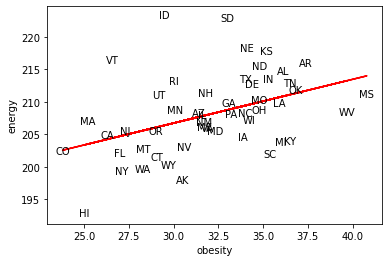

In [40]:
# Plot the obesity vs energy and plot the line
stateobesity_tweetcalories.plot.scatter(x = "obesity", y = "energy", c = "white")
for x,y,l in zip(stateobesity_tweetcalories.obesity, stateobesity_tweetcalories.energy, stateobesity_tweetcalories.state):
    plt.annotate(l, (x,y), textcoords="offset points", xytext=(0,-2), ha='center') 
plt.plot(X, Y_pred, color='red')
plt.show()